# Project description

### Summary

This project takes daily temperature data from Berlin Tempelhof for the years 1946 to July 2022 and forecasts based on this data the daily temperatre for the next three days. 


### Steps

1. Import packages
2. Get and clean data
3. Train-test split
4. Exploratory data analysis (descriptive statistics and plotting)
5. Baseline model that models trend and seasonality
6. Model time dependence of the remainder using an autoregressive (AR) model
7. Compare statistical output of different AR models
8. Test the remainder for stationarity 

---
10. Create lags
11. Plot ACF and PACF
12. AR and ARIMA models
13. Evaluate on test data (cross-validation?)
14. Forecast for the next days (based on AR or ARIMA??)



# Imports

In [3]:
import os

import pandas as pd
import seaborn as sns
import numpy as np

from pandas import Grouper
from pandas import read_csv
from pandas import DataFrame
from matplotlib import pyplot

import matplotlib.pyplot as plt
from plotly.offline import iplot
import plotly.graph_objects as go

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA

import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Set the graph size
sns.set(rc={'figure.figsize':(11, 4)})

In [5]:
ls

README.md                   requirements.txt
data/                       temperature_forecast.ipynb


# Read data

### Berlin temperature data

FILE FORMAT (MISSING VALUE CODE IS -9999):

* 01-06 SOUID: Source identifier
* 08-15 DATE : Date YYYYMMDD
* 17-21 TG   : mean temperature in 0.1 &#176;C
* 23-27 Q_TG : Quality code for TG (0='valid'; 1='suspect'; 9='missing')

In [6]:
date = ['DATE']

In [7]:
df = pd.read_csv('data/ECA_blended_Berlin/TG_STAID002759.txt', sep=',', skiprows=18, skipinitialspace=True, parse_dates=date)
#, parse_dates=date

In [8]:
df.head(3)

,SOUID,DATE,TG,Q_TG
0,127488,1876-01-01,22,0
1,127488,1876-01-02,25,0
2,127488,1876-01-03,3,0


In [9]:
df.columns

Index(['SOUID', 'DATE', 'TG', 'Q_TG'], dtype='object')

In [10]:
df.dtypes

SOUID             int64
DATE     datetime64[ns]
TG                int64
Q_TG              int64
dtype: object

# Train-test split

In [11]:
def train_test(df):
    '''Split the last year of data into test data. Return test and train data'''
    df_train = df[:-365]
    df_test = df[-365:]
    return df_train, df_test

In [12]:
# Execute train test function and create test and train datasets
df, df_test = train_test(df)

#### Save in CSV

In [13]:
df_test.to_csv('data/temp_test.csv')

# Clean data and add features

### Cleaning functions

In [14]:
def clean_cols(df):
    ''' Return dataframe with lower case column names'''
    df.columns = map(str.lower, df.columns)
    return df

In [15]:
def date_cols(df):
    ''' Crate year, month, day and weekday columns. Return modified dataframe'''
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['weekday'] = df.index.weekday
    df['day'] = df.index.day
    return df

In [16]:
def date_to_index(df):
    '''Return dataframe with datetime column as the index'''
    df.set_index('date', inplace=True, drop=False)
    return df

In [17]:
def missing_to_nan(df):
    '''Replace missing values coded as -9999 with np.nan. Return dataframe'''
    df['tg'] = df['tg'].replace(-9999, np.nan)
    return df


### Call cleaning functions on Berlin temperature data

In [18]:
df = clean_cols(df)

In [19]:
df = date_to_index(df)

In [20]:
df = date_cols(df)

In [21]:
df = missing_to_nan(df)

In [22]:
df.index.year

Int64Index([1876, 1876, 1876, 1876, 1876, 1876, 1876, 1876, 1876, 1876,
            ...
            2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021],
           dtype='int64', name='date', length=53081)

### Create celsius 1 column

In [23]:
df['temp'] = df.tg/10

In [24]:
#Check fo missing values
df.isna().sum()

souid        0
date         0
tg         195
q_tg         0
year         0
month        0
weekday      0
day          0
temp       195
dtype: int64

### Missing values

In [25]:
# Creating yearly averages
g = df.groupby(pd.Grouper(freq='Y')).mean()

In [26]:
# Find value counts for variable indicating data quality (q_tg) - when 9, the value is missing 
df["q_tg"].value_counts()

0    52885
9      195
1        1
Name: q_tg, dtype: int64

In [27]:
# Find range of years with missing values
df['year'].loc[(df['q_tg']==9)].describe()[['min', 'max']]

min    1945.0
max    1945.0
Name: year, dtype: float64

# Exploratory data analysis

## Descriptive statistics

In [28]:
df.head(3)

,souid,date,tg,q_tg,year,month,weekday,day,temp
date,,,,,,,,,
1876-01-01,127488,1876-01-01,22.0,0,1876,1,5,1,2.2
1876-01-02,127488,1876-01-02,25.0,0,1876,1,6,2,2.5
1876-01-03,127488,1876-01-03,3.0,0,1876,1,0,3,0.3


In [29]:
df.dtypes

souid               int64
date       datetime64[ns]
tg                float64
q_tg                int64
year                int64
month               int64
weekday             int64
day                 int64
temp              float64
dtype: object

In [30]:
df.shape

(53081, 9)

In [31]:
df.tail(3)

,souid,date,tg,q_tg,year,month,weekday,day,temp
date,,,,,,,,,
2021-04-28,111448,2021-04-28,109.0,0,2021,4,2,28,10.9
2021-04-29,111448,2021-04-29,113.0,0,2021,4,3,29,11.3
2021-04-30,111448,2021-04-30,83.0,0,2021,4,4,30,8.3


In [32]:
df.describe()

,souid,tg,q_tg,year,month,weekday,day,temp
count,53081.000000,52886.000000,53081.000000,53081.000000,53081.000000,53081.000000,53081.000000,52886.000000
mean,119398.780581,93.769599,0.033082,1948.165935,6.513856,3.000000,15.729112,9.376960
std,8024.310022,78.771228,0.544513,41.953926,3.450539,2.000019,8.799924,7.877123
min,111448.000000,-226.000000,0.000000,1876.000000,1.000000,0.000000,1.000000,-22.600000
25%,111448.000000,33.000000,0.000000,1912.000000,4.000000,1.000000,8.000000,3.300000
50%,111448.000000,94.000000,0.000000,1948.000000,7.000000,3.000000,16.000000,9.400000
75%,127488.000000,157.000000,0.000000,1984.000000,10.000000,5.000000,23.000000,15.700000
max,128124.000000,305.000000,9.000000,2021.000000,12.000000,6.000000,31.000000,30.500000


In [33]:
#Accessing data for specific date
df.loc['2017-10-30']

souid                   111448
date       2017-10-30 00:00:00
tg                        61.0
q_tg                         0
year                      2017
month                       10
weekday                      0
day                         30
temp                       6.1
Name: 2017-10-30 00:00:00, dtype: object

In [34]:
# Descriptive statistics for February 1900
df.loc['1900-02'].describe()

,souid,tg,q_tg,year,month,weekday,day,temp
count,28.0,28.000000,28.0,28.0,28.0,28.0000,28.000000,28.000000
mean,127488.0,13.107143,0.0,1900.0,2.0,3.0000,14.500000,1.310714
std,0.0,40.632353,0.0,0.0,0.0,2.0367,8.225975,4.063235
min,127488.0,-46.000000,0.0,1900.0,2.0,0.0000,1.000000,-4.600000
25%,127488.0,-21.250000,0.0,1900.0,2.0,1.0000,7.750000,-2.125000
50%,127488.0,1.500000,0.0,1900.0,2.0,3.0000,14.500000,0.150000
75%,127488.0,44.500000,0.0,1900.0,2.0,5.0000,21.250000,4.450000
max,127488.0,101.000000,0.0,1900.0,2.0,6.0000,28.000000,10.100000


In [35]:
# Descriptive statistics for February 2000
df.loc['2000-02'].describe()

,souid,tg,q_tg,year,month,weekday,day,temp
count,29.0,29.000000,29.0,29.0,29.0,29.000000,29.000000,29.000000
mean,111448.0,44.689655,0.0,2000.0,2.0,2.931034,15.000000,4.468966
std,0.0,27.797872,0.0,0.0,0.0,2.034191,8.514693,2.779787
min,111448.0,-6.000000,0.0,2000.0,2.0,0.000000,1.000000,-0.600000
25%,111448.0,24.000000,0.0,2000.0,2.0,1.000000,8.000000,2.400000
50%,111448.0,46.000000,0.0,2000.0,2.0,3.000000,15.000000,4.600000
75%,111448.0,66.000000,0.0,2000.0,2.0,5.000000,22.000000,6.600000
max,111448.0,100.000000,0.0,2000.0,2.0,6.000000,29.000000,10.000000


In [36]:
# Drop all missing values
df.dropna(inplace=True)

In [37]:
#Create yearly mean temperature column 
yearly_temp = df.resample("1y")[['temp']].mean()

### Create three datasets   - pre-WW2, post-WW2, and 2017-2022

This is done as the data for year 1945 is missing completely.
For forecasting only the post WW2 data will be used as the model does not accept missing values. 
For plotting the entire dataset will be used.

1. 1876 - 1944
2. 1946 - 2022
3. 2017 - 2022 (for forecasting the next day's temperature, only a few years are needed)

In [38]:
df_post = df.loc[(df.year>1945)]
df_pre = df.loc[(df.year < 1945)]
df_five = df.loc['2017-5-1':]

# df_five = df.loc[(df.year > 2016)]

## Plotting

In [39]:
df.isna().sum()

souid      0
date       0
tg         0
q_tg       0
year       0
month      0
weekday    0
day        0
temp       0
dtype: int64

In [40]:
df.index.year

Int64Index([1876, 1876, 1876, 1876, 1876, 1876, 1876, 1876, 1876, 1876,
            ...
            2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021],
           dtype='int64', name='date', length=52886)

In [41]:
yearly_temp

,temp
date,
1876-12-31,9.320219
1877-12-31,9.727945
1878-12-31,10.236712
1879-12-31,8.180548
1880-12-31,9.805191
...,...
2017-12-31,10.712055
2018-12-31,11.755616
2019-12-31,11.824384


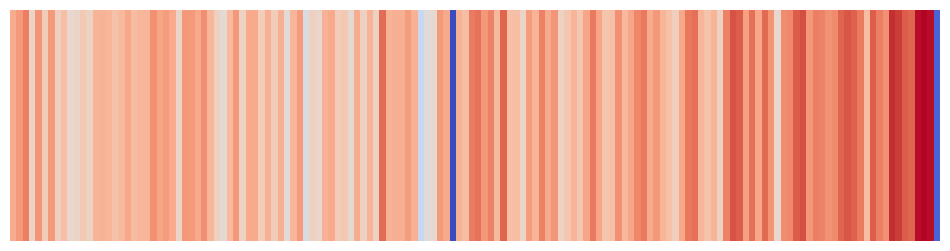

In [42]:
# Plot a heatmap of the mean yearly temperatures from 1876 to 2021
# the redder the stripes the warmer the yearly mean temperature. 
# The dark blue stripe in the middle is the missing 1945 year.

plt.figure(figsize=(12, 3))
sns.heatmap(yearly_temp.T, cmap='coolwarm', 
            xticklabels=[], yticklabels=[], # switch off all labels
            cbar=False
           )
_ = plt.xlabel(None)

In [43]:
# Plot temperature 
def simple_plot(df):
    '''Plot temperature in celsius.'''
    df['temp'].plot(linewidth=0.5)

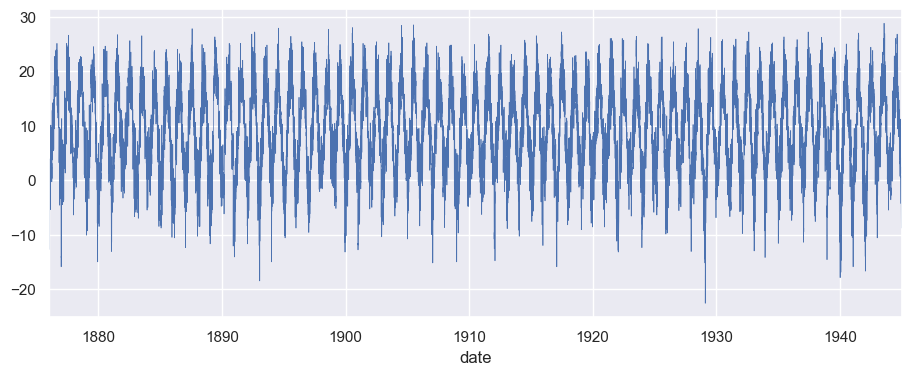

In [44]:
# Plot pre WW2 temperature
simple_plot(df_pre)

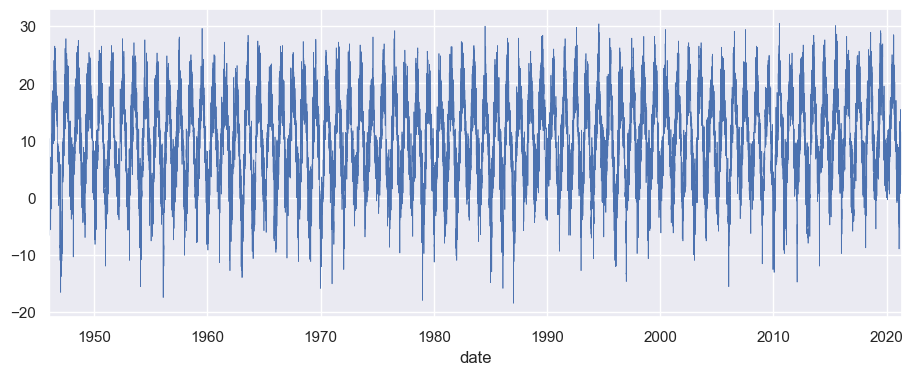

In [45]:
# Plot post- WW2 temperature
simple_plot(df_post)

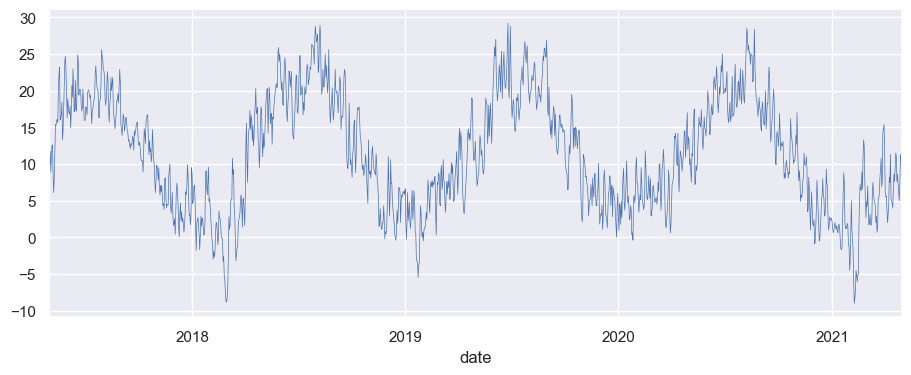

In [46]:
simple_plot(df_five)

### Plot specific years, months, days

In [47]:
def plot_year(df, year=2000):
    '''Plot a specific year, default is 2000.'''
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(1, 364)
    y = df['temp'].loc[(df.year == year)]
    ax.plot(y)
    plt.ylim([-10, 30])
    # df['temp'].loc[(df.year == year)].plot(linewidth=0.5)


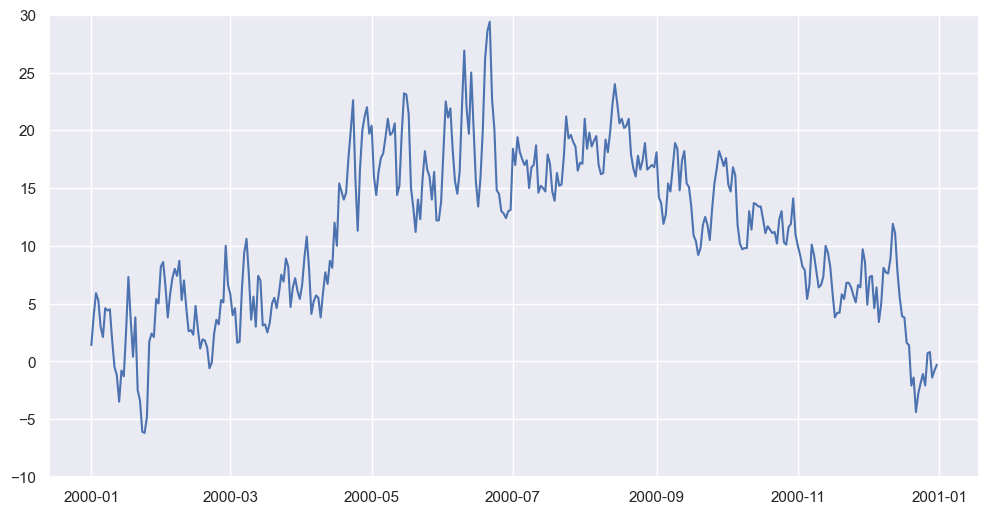

In [48]:
plot_year(df_post, 2000)

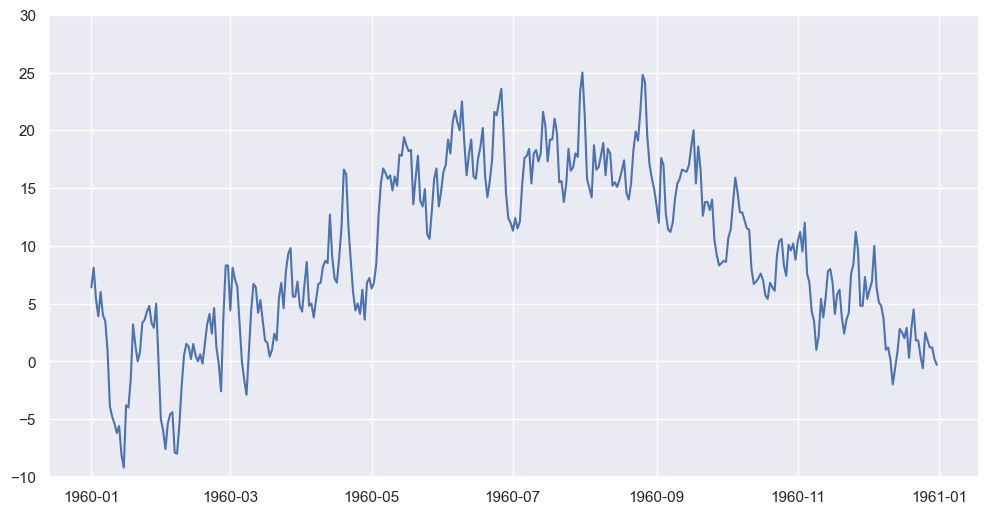

In [49]:
plot_year(df_post, 1960)

In [50]:
def plot_month_year(df = df_post, month=1, year= 2000):
    '''Plot a specific month.'''
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(1, 30)
    y = df['temp'].loc[(df.month == month) & (df.year == year)]
    ax.plot(y) 
            #title=f'Temperature in {month}th month in {year} in Berlin Tempelhof (1946-2022)')
    plt.title(f'Temperature in {month}th month in {year} in Berlin Tempelhof (1946-2022)')
    if (month > 5) & (month <=9):
        plt.ylim([8, 30]) # define y-axis (temperature) limits for summer months
    elif (month > 10) | (month <4):
        plt.ylim([-12, 20]) # define y-axis (temperature) limits for winter months
    else:
        plt.ylim([0, 20]) # define y-axis (temperature) limits for remaining months



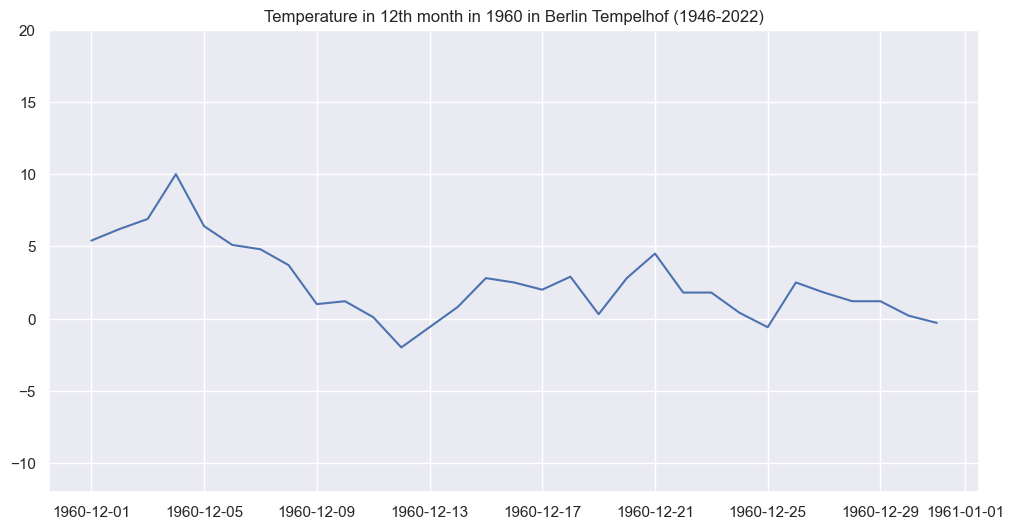

In [51]:
plot_month_year(df_post, 12, 1960)

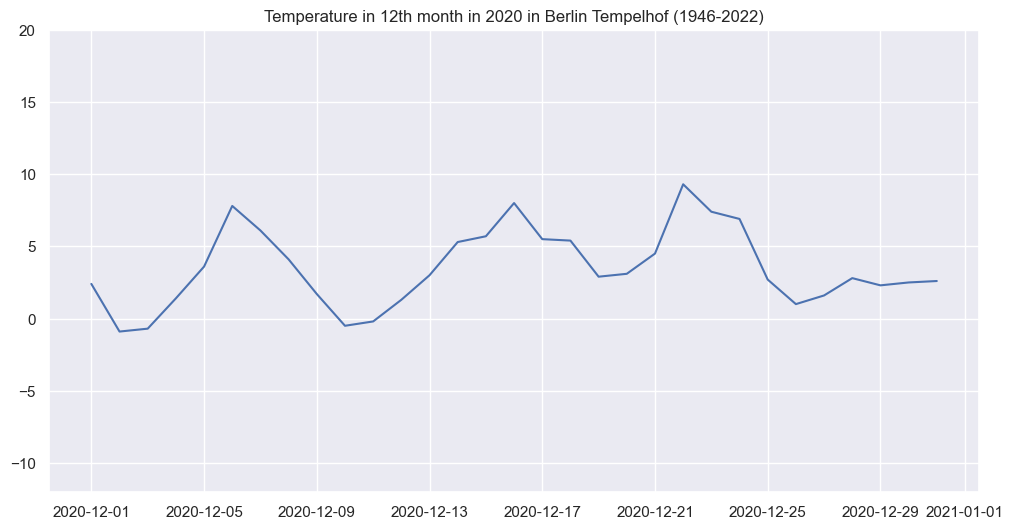

In [52]:
plot_month_year(df_post, 12, 2020)

In [53]:
# Read in data for plotting
series = pd.read_csv('data/ECA_blended_Berlin/TG_STAID002759.txt', sep=',', index_col=0, skiprows=18, skipinitialspace=True, parse_dates=['DATE'], squeeze=True)
series['DATE'] = pd.to_datetime(series['DATE'])
series = series.set_index('DATE', drop=False) 



In [54]:
# Drop February 29th days (leap years interfere with plotting stacked years due to shape of year)
series = series.loc[~(series['DATE'].dt.month.eq(2) & series['DATE'].dt.day.eq(29))] 

In [55]:
# Drop unnecessary columns
series = series.drop(['Q_TG', 'DATE'], axis= 1)

In [56]:
series['TG'] = series['TG']/10 

In [57]:
def stacked_yearly_plots(df = series, year_lowlim = 2010, year_uplim = 2020):
    '''Plot the entire year for selected years in a stacked line plot'''
    
    
    groups = series.groupby(Grouper(freq='A'))
    years = DataFrame() # empty dataframe
    
    for date, tempcol in groups:
        if (date.year >= year_lowlim) & (date.year <= year_uplim):
            years[date.year] = [i[0] for i in tempcol.values] # Generate a dataframe with years as columns,
            # the days of the year as index, and temperature as values 
    years.plot(subplots=True, legend=True)
    #pyplot.show()

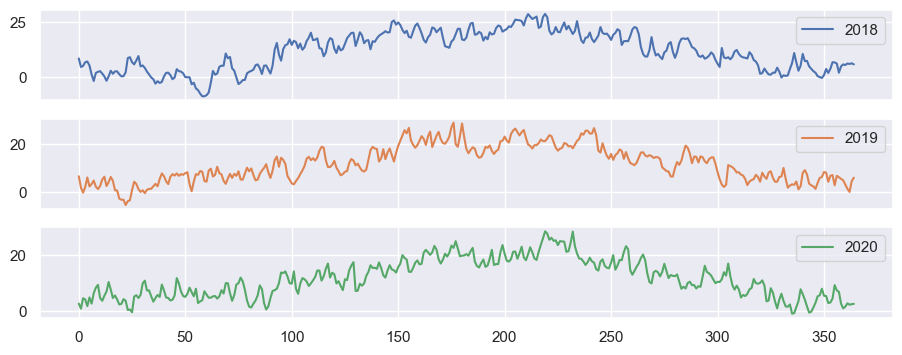

In [58]:
stacked_yearly_plots(df = series, year_lowlim = 2018, year_uplim = 2020)

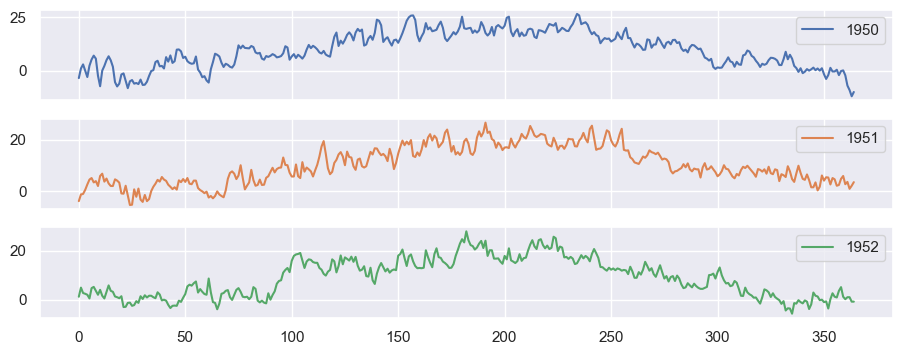

In [59]:
stacked_yearly_plots(df = series, year_lowlim = 1950, year_uplim = 1952)

### Average yearly temperature

<AxesSubplot:title={'center':'Average yearly temperature in Berlin Mitte (1876-2020)'}, xlabel='date'>

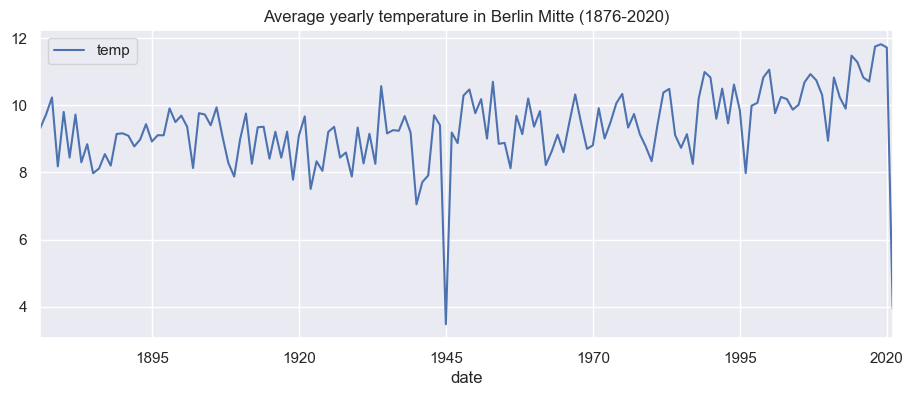

In [60]:
# Plot the yearly average temperature
yearly_temp = df.resample("1y")[['temp']].mean()
yearly_temp.plot(title='Average yearly temperature in Berlin Mitte (1876-2020)')

In [61]:
# Plot average monthly temperature

def monthly_mean_temp(df = df_post, month_chosen = 1):
    '''Plot average temperature of month_chosen'''
    monthly_temp = df.resample("1m")[['temp']].mean() # get the mean monthly temperature
    monthly_temp['date'] = monthly_temp.index
    month_temp = monthly_temp.loc[(monthly_temp.date.dt.month.eq(month_chosen))] # keep only chosen months
    month_temp.drop(['date'], axis=1, inplace=True)
    month_temp.plot(title=f'Average {month_chosen}th month temperature in Berlin Tempelhof (1946-2022)')
    

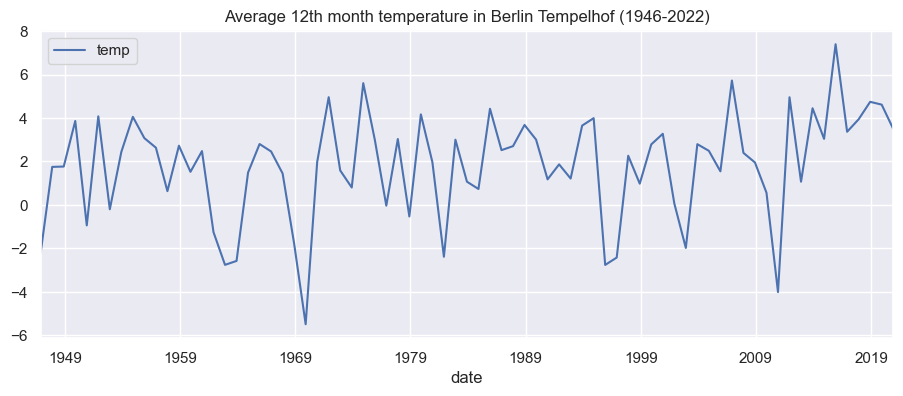

In [62]:
monthly_mean_temp(month_chosen = 12)

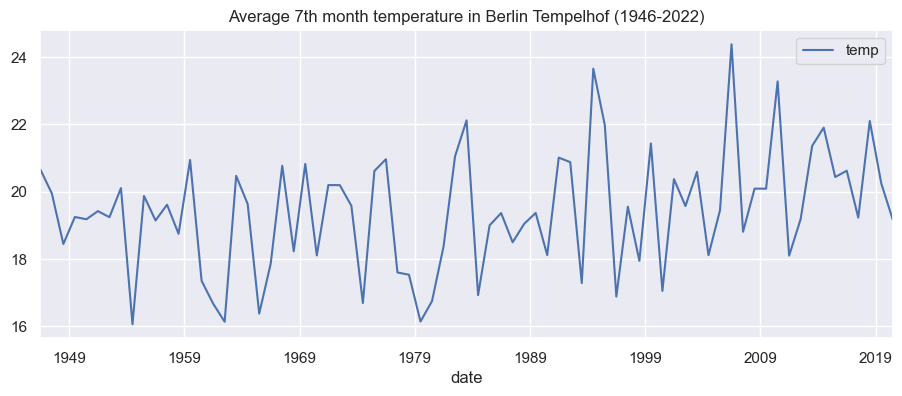

In [63]:
monthly_mean_temp(month_chosen = 7)

### Mean monthly temperature

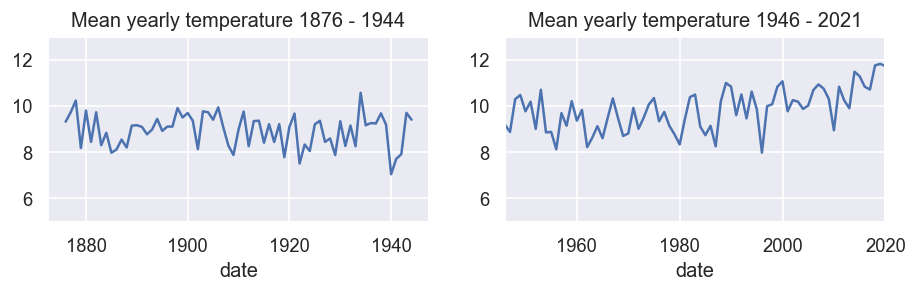

In [64]:
plt.rcParams.update({'figure.figsize':(9,2), 'figure.dpi':120})

fig, ax = plt.subplots(1,2)
figsize = [6, 12]
ax[0].set_ylim(5,13)
ax[1].set_ylim(5,13)
ax[1].set_xlim(1946,2020)
df_pre.groupby(df_pre.index.year)['temp'].mean().plot(title= 'Mean yearly temperature 1876 - 1944', ax = ax[0])
df_post.groupby(df_post.index.year)['temp'].mean().plot(title= 'Mean yearly temperature 1946 - 2021', ax = ax[1])
plt.show()

# Time series decomposition 


Time series decomposition =  a mathematical procedure which transforms a time series into multiple different time series. The original time series is often split into 3 component series:

- Seasonal: Patterns that repeat within a fixed period of time. E.g. the four seasons of a year. 

- Trend: The underlying trend of the metrics. E.g. mean temperatures increasing over the past decades. 

- Remainder: Also called noise, error or residual. This is the residual of the original time series after the seasonal & trend series are subtracted from it. 


In [65]:
df_five_t = df_five[['temp']]
df_post_t = df_post['temp']

In [122]:
plt.rcParams.update({'figure.figsize': (10,10)})

In [125]:
# With statsmodels seasonal_decompose (returns the trend, seasonality and remainder component)

result = seasonal_decompose(df_five_t, model='additive', period=365, extrapolate_trend='freq')
result_2 = seasonal_decompose(df_post['temp'], model='additive', period=365)

Text(0.5, 0.98, '2')

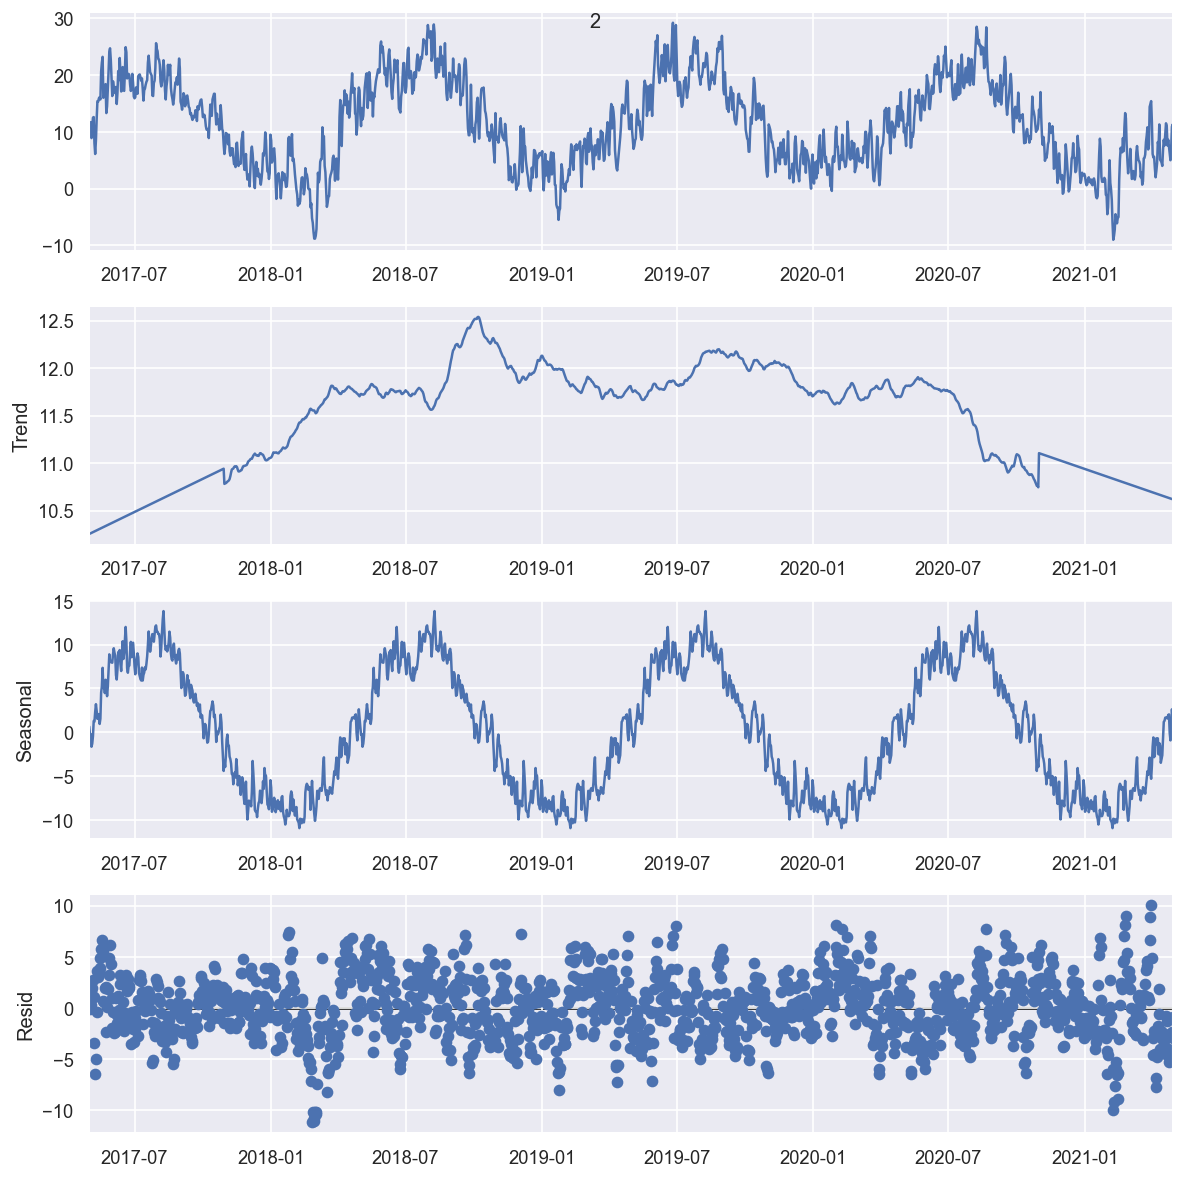

In [126]:
result.plot().suptitle('Additive decomposition of 2017-2021 series' fontsize=12)

Text(0.5, 0.98, 'Additive decomposition of 1946-2021 series')

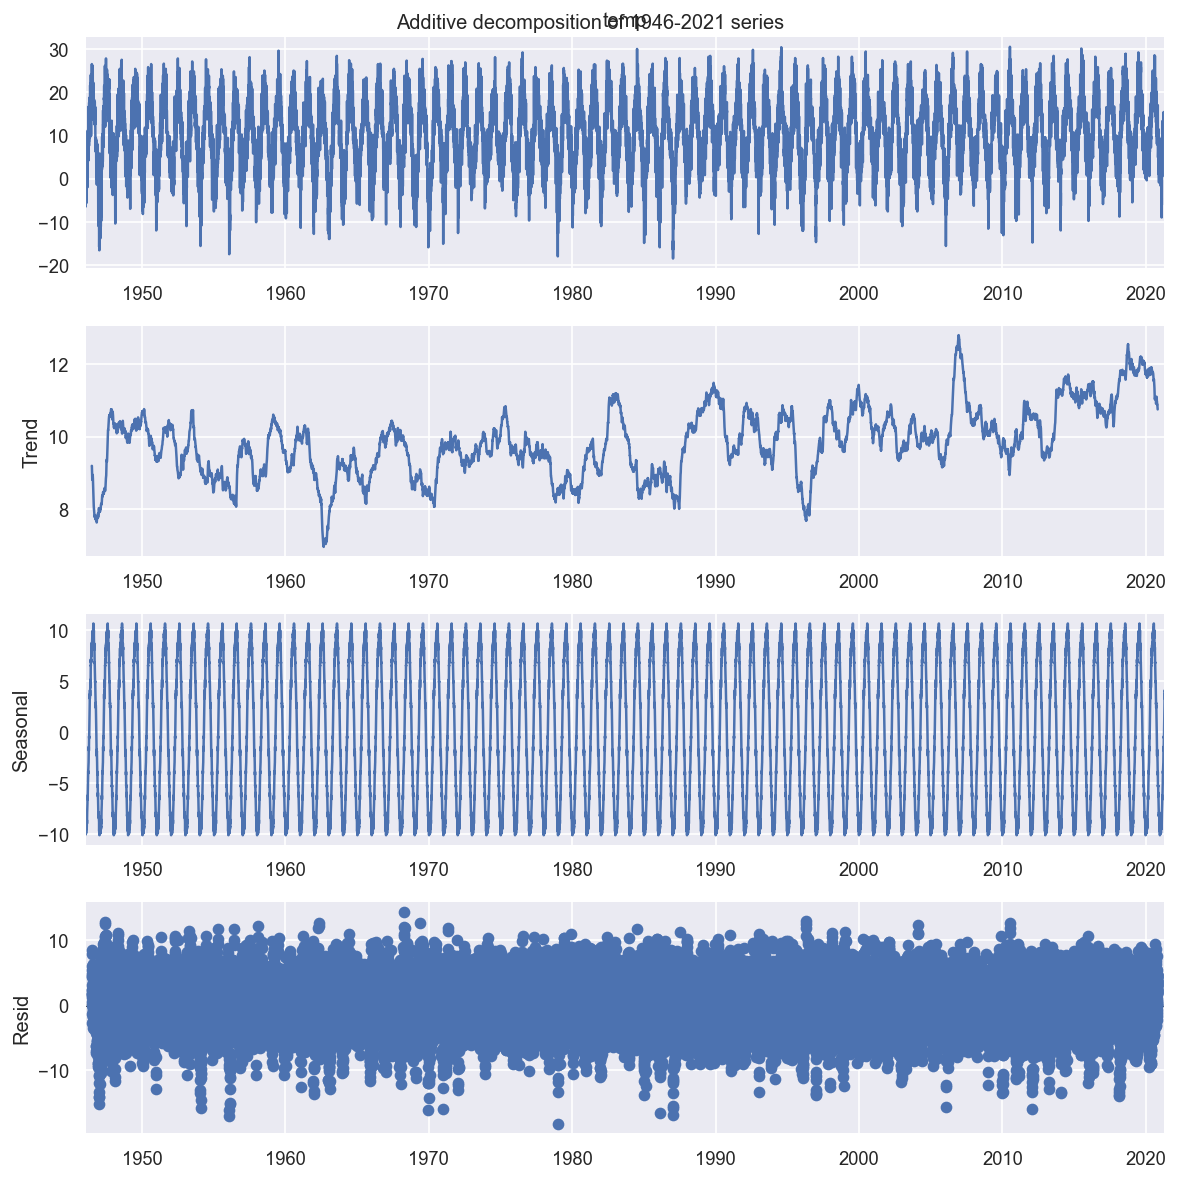

In [128]:
result_2.plot().suptitle('Additive decomposition of 1946-2021 series', fontsize=12)

## Baseline model to model trend and seasonality

In [93]:
# Get timestep - this is just a number running from 0 to the n of observations in dataframe
df_post['timestep'] = list(range(len(df_post)))
df_five['timestep'] = list(range(len(df_five)))


In [94]:
def X_and_y(df):
    '''Define X and Y to be used to predict the linear trend'''
    X = df[['timestep']]
    y = df['temp']
    return X, y

### Model trend of temperature over time - manual without statsmodels assuming linear dependence

In [95]:
# Model the (upwards or downward) trend of the temperature over time 
#- we assume the trend to be liner based on visual inspection above 

def pred_trend(df, plot=True):
    '''Predict and plot the time-trend (time-dependence) of the temperature: linear regression on timestemp'''
    
    X, y = X_and_y(df)
    m = LinearRegression()
    m.fit(X, y)
    df['trend'] = m.predict(X)
    print(f'The slope of the trend: {m.coef_}')
    if plot:
        df[['temp', 'trend']].plot()
        
    return df

The slope of the trend: [5.86853663e-05]


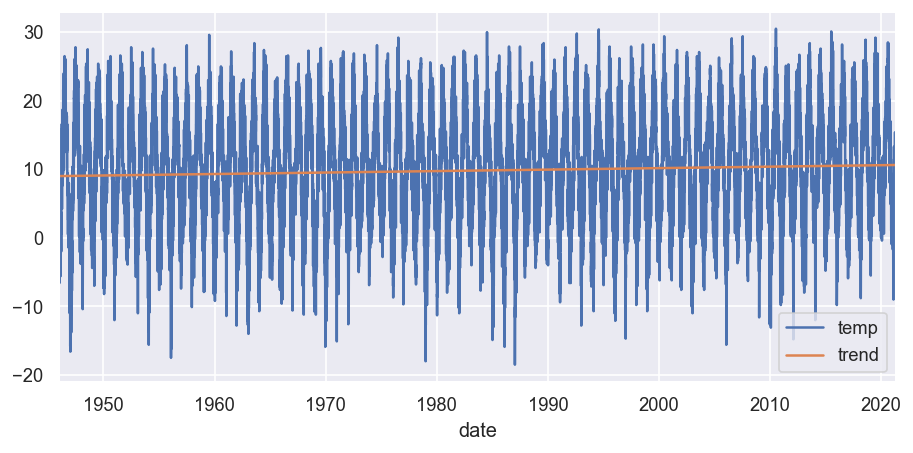

In [96]:
df_post=pred_trend(df_post)

The slope of the trend: [-0.00315766]


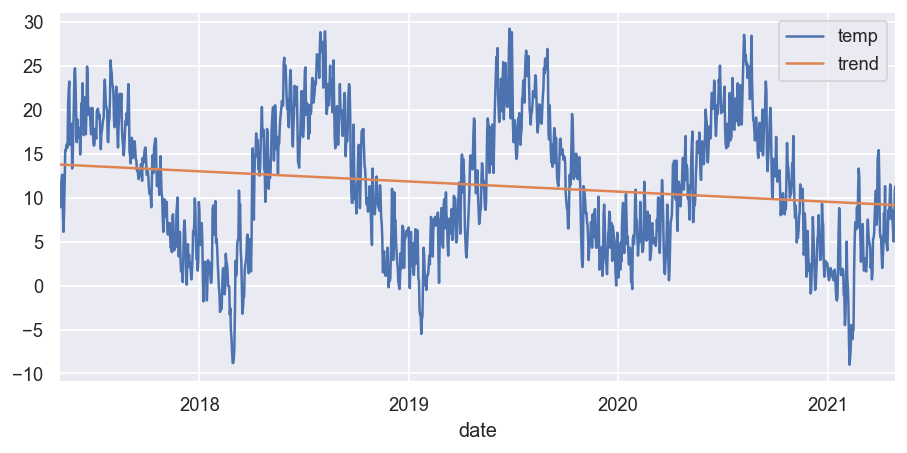

In [97]:
df_five=pred_trend(df_five)

<AxesSubplot:title={'center':'Trend of mean temperature, 2017-2021'}, xlabel='date'>

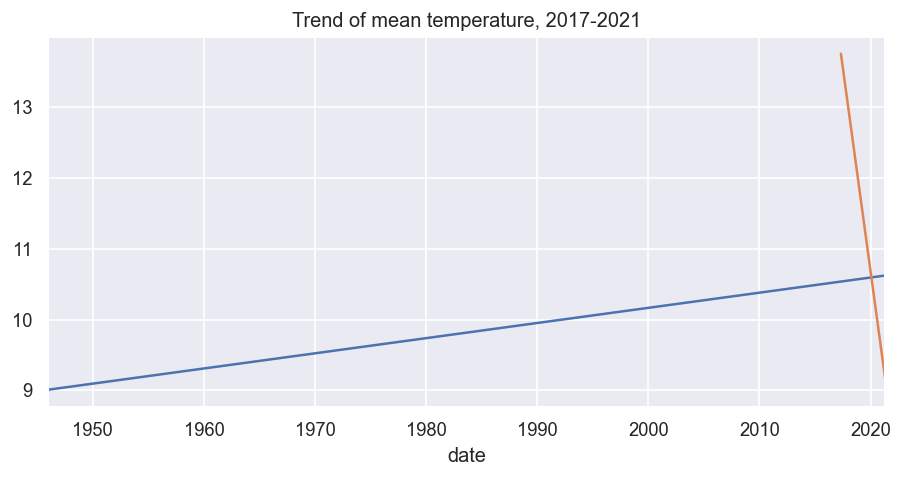

In [98]:
plt.rcParams.update({'figure.figsize':(9,4), 'figure.dpi':120})
df_post['trend'].plot(title = 'Trend of mean temperature, 1946-2021')
df_five['trend'].plot(title = 'Trend of mean temperature, 2017-2021')

#### Conclusion: A linear model of the trend is not appropriate

### Model the seasonality of temperature

1. Create seasonal dummies for each month 
2. Set X = seasonal dummies and timestep, Y = temperature
3. Linear regression 

In [99]:
def seasonal_dum(df):
    '''Get monthly seasonal dummies and join them to the dataframe. Return dataframe.'''
    seasonal_dummies = pd.get_dummies(df.index.month, drop_first=True, prefix='month').set_index(df.index)
    df = df.join(seasonal_dummies)
    return df

In [100]:
def get_X_months(df):
    '''Place monthly dummies and the timestep as the independent variable'''
    X = df[df.columns[df.columns.isin(['timestep', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12'])]]
    return X

In [101]:
def model_seasonality(df, plot=False):
    '''Predict and plot the seasonal trend of temperature using linear regression, 
    with seasonal dummies and the timestep as independent variables. Return dataframe.'''
    length = len(df)
    X_old, y = X_and_y(df)
    X = get_X_months(df)
    y_new = y[-length:]
    m = LinearRegression()
    m.fit(X, y_new)
    df['trend_seasonal'] = m.predict(X)
    if plot==True:
        fig,ax =  plt.subplots() 
        ax.set_ylim(-20,35)
        df[['temp', 'trend_seasonal']].plot(title = 'Temperature and seasonal trend', ax = ax)
        plt.show()
    return df


In [102]:
df_post = seasonal_dum(df_post)
df_five = seasonal_dum(df_five)

In [103]:
X = get_X_months(df_post)
X_five = get_X_months(df_five)

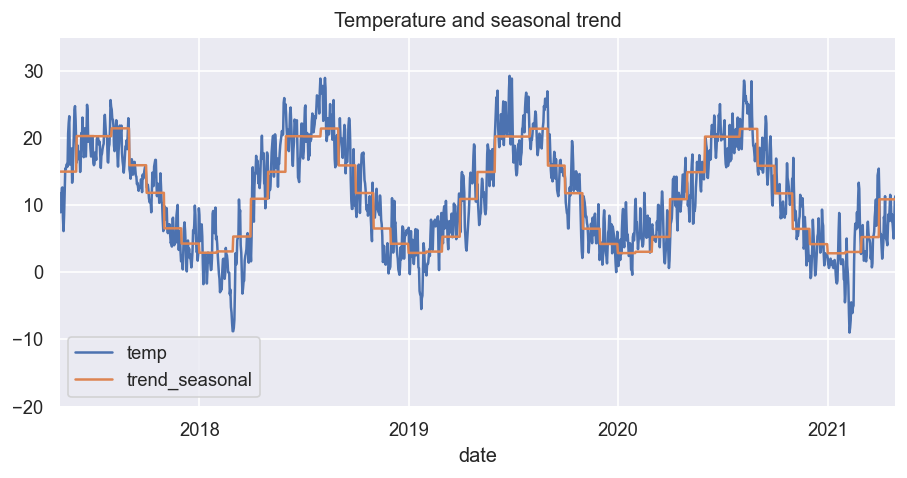

In [104]:
df_five = model_seasonality(df_five, plot=True)

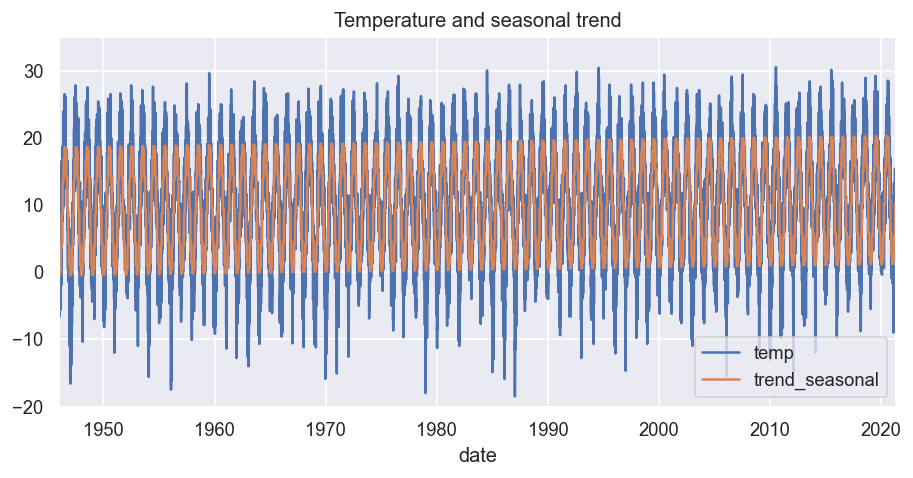

In [105]:
df_post = model_seasonality(df_post, plot=True)

### Extract and plot remainder

In [106]:

def get_remainder(df, plot=False):
    '''Extract remainder by subtracting the seasonal trend from temperature. Plot remainder'''
    df['remainder'] = df['temp'] - df['trend_seasonal']
    if plot==True:
        fig,ax =  plt.subplots() 
        ax.set_ylim(-25,20)
        df['remainder'].plot(title = f'Remainder for years {min(df.year)} - {max(df.year)}', ax = ax)
        plt.show()
    return df


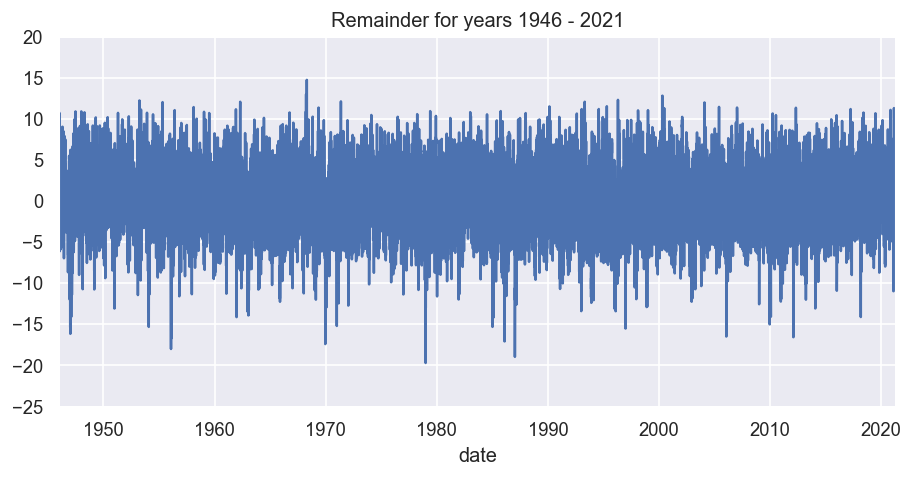

In [107]:
df_post = get_remainder(df_post, plot=True)

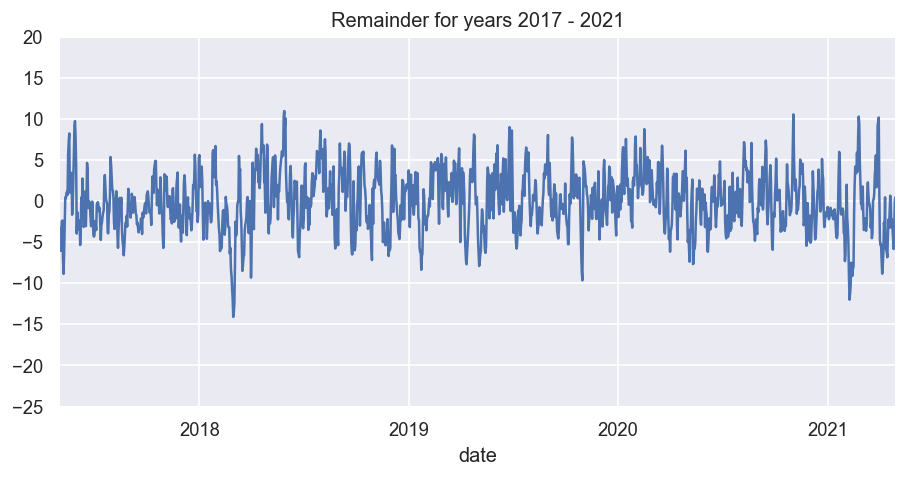

In [108]:
df_five = get_remainder(df_five, plot=True)

### Save remainder in csv

In [109]:
df_post['remainder'].to_csv('data/post_remainder.csv')
df_five['remainder'].to_csv('data/five_remainder.csv')

# Check for stationarity - Augmented   Dickey-Fuller test


**What is stationarity:**

- = the statistical properties of the series do not depend on the time at which the series is observed.

**Basic conditions of stationarity:**

- constant mean
- constant standard deviation
- no seasonality

**Why is stationarity important:**

- For most time-series forecasting models (ARIMA, AR) to work, the data must be stationary.

**How to detect stationarity:**
- visually
- global vs local tests
- augmented-Dicky-Fuller test

**What is the ADF and what does it detect:**

- ADF is a unit root test (presence of unit root in series --> non-stationary series)
- The ADF detects non-stationarity in the long-term cycle = the trend of the series.
- ADF does not detect seasonality (periodic behaviour/pattern that is predictable, e.g. monthly)


**How to transform a non-stationary time-series into stationary:** 
- taking first (or higher order) differences to stabilize the mean (=computing the difference between consecutive observations)
- transformations (e.g. log) can help to stabilize the variance
- taking out seasonality


Some sources: 

* Great intuitive explanation for unit root: https://stats.stackexchange.com/questions/29121/intuitive-explanation-of-unit-root
* on stationarity and differencing: https://otexts.com/fpp2/stationarity.html
* Definition of stationarity: Probability, Random variables and stochastic processes 4th edition, Papoulis and Pillai


In [110]:
# Unit root test

def check_stationarity(df):
    '''Print out the main results of the Augmented Dicky Fuller test in a nice format.'''
    result = adfuller(df)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items(): # pvalues are a dict that is the fourth indexed item
        print('\t%s: %.3f' % (key, value)) # prints p-values with 3 digit accuracy

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m") # prints stationary in green
    else:
        print("\x1b[31mNon-stationary\x1b[0m") # prints non-stationary in red

# Source: https://machinelearningmastery.com/time-series-data-stationary-python/


In [111]:
check_stationarity(df_post['temp'])

ADF Statistic: -12.932323
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


In [112]:
check_stationarity(df_post['remainder'])

ADF Statistic: -23.392011
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


In [113]:
check_stationarity(df_five['temp'])

ADF Statistic: -2.299956
p-value: 0.171982
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Non-stationary


In [114]:
check_stationarity(df_five['remainder'])

ADF Statistic: -13.004366
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Stationary


 ### Conclusion: 
 - To use an AR model with the five year data to forecast the next days, we will use the remainder

### Save pre and post 1945 data

In [ ]:
df_post.to_csv('data/df_post.csv', index_label =False)
df_five.to_csv('data/df_five.csv', index_label =False)

In [ ]:
def save_read_csv(df, name):
    df.to_csv(f'data/{name}.csv', index_label =False)
    df = pd.read_csv(f'data/{name}.csv')
    df.index = pd.to_datetime(df.index)
    print(df.index.dtype)
    return df
    

In [ ]:
df_post = save_read_csv(df_post, 'df_post')
df_five = save_read_csv(df_five, 'df_five')

# Time-series forecasting models

We can model time-series in three ways: 

1. Autoregressive (AR) model

$$ y_t = w_0 + w_1 y_{t-1} + w_2 y_{t-2} + .. + w_n y_{t-n} $$

* In the autoregressive model, output variable depends linearly on its own previous values. 

2. Moving average (MA) model

$$ y_t = \epsilon_t + \beta_1 \epsilon_{t-1} + \beta_2 \epsilon_{t-2} +  .. + \beta_n \epsilon_{t-n} $$

* the current value is a result of unexpected events. This model uses the dependency between an observation and a residual error from a moving average model applied to lagged observations. 

3. Autoregressive moving average (ARMA) model

$$ y_t = w_1 y_{t-1} + w_2 y_{t-2} + .. + w_n y_{t-n} + \epsilon_t + \beta_1 \epsilon_{t-1} + \beta_2 \epsilon_{t-2} +  .. + \beta_n \epsilon_{t-n} $$

* Combination of two models above 


* + the ARIMA - the autoregressive *Integrated* moving average model


# Forecast with an autoregressive (AR) model

The first-order autoregression, AR(1):
$$ y_t = w_0 + w_1 y_{t-1} + \epsilon $$

* value at time t depends *only* on the value at time t-1

The second-order autoregression, AR(2):
$$ y_t = w_0 + w_1 y_{t-1} + w_2 y_{t-2} + \epsilon $$

* value at time t depends on value at time t-1 and t-2


 ### Plot lags of the remainder against the remainder and calculate correlation coefficients
 
 “A stationary time series process […] is said to be weakly dependent if  and  are “almost independent” as h” goes to infinity. “In other words, as the variables get farther apart in time, the correlation between them becomes smaller and smaller.

### Lags 

In [ ]:
# Add lag1 feature - TAKE THIS OUT

df_post['lag1'] = df_post['remainder'].shift(1)
df_five['lag1'] = df_five['remainder'].shift(1)


In [ ]:
df_post['timestep'] = df_post['timestep'] +1

In [ ]:
df_post.dropna(inplace=True)

In [ ]:
def X_full_y_full(df):
    X_full = df.drop(['tg', 'temp', 'q_tg', 'month', 'weekday', 'year', 'day', 'date', 'souid', 'trend_seasonal', 'remainder', 'trend'], axis=1)
    y_full = df['temp']
    return X_full, y_full

In [ ]:
X_full, y_full = X_full_y_full(df_post)

In [ ]:
y_full.dtype

In [ ]:
X_full

In [ ]:
m_full = LinearRegression()
m_full.fit(X_full, y_full)

In [ ]:
df_post['full_model'] = m_full.predict(X_full)


In [ ]:
df_post[['temp', 'full_model', 'trend_seasonal']].plot()

In [ ]:
df_post['remainder_full_model'] = df_post['temp'] - df_post['full_model']

In [ ]:
df_post[['remainder', 'remainder_full_model']].plot()

In [ ]:
#remainder = df_post['remainder']
df_post['pred_var'] = df_post['remainder']

## Auto-correlation function (ACF) and Partial autocorrelation function (PACF)


**ACF:**

* The correlation between the observation at the current time spot and the observations at previous time spots.

**PACF:**

* The correlation between observations at two time spots given that we consider both observations are correlated to observations at other time spots. E.g. 


#### When to use autoregressive (AR), Moving average (MA) or an Autoregressive integrated moving average (ARIMA) model based on ACF and PACF: 

**AR process**: the ACF plot will gradually decrease and simultaneously the PACF should have a sharp drop after p significant lags. 

**MA process**: the ACF should show a sharp drop after a certain q number of lags while PACF should show a geometric or gradual decreasing trend. 

**ARIMA:** if both ACF and PACF plots demonstrate a gradual decreasing pattern.

Source: https://towardsdatascience.com/identifying-ar-and-ma-terms-using-acf-and-pacf-plots-in-time-series-forecasting-ccb9fd073db8

In [ ]:
# ACF
plt.rcParams.update({'figure.figsize':(9,4), 'figure.dpi':120})

plot_acf(df_post['pred_var']);

In [ ]:
plot_pacf(df_post['pred_var']);

#### Conclusion of ACF and PACF

- The ACF shows a slow decay
- The PACF shows a drop after a certain lag /// OR an exponential and slow decay?? 

--> Make both Arima and AR(p) just in case - not sure how to interpret

## Bayesian information criteria (BIC)

**Select number of lags to use in the AR model based on BIC**

BIC = A method to determine statistically how many of the lags we want to use in predicting the error of our model. It helps us to decide the balance between how well our model is performing (i.e. fitting the data) vs how complex it is - they penalize more complex models for the benefit of generalisability. 

In [ ]:
selected_order = ar_select_order(df_post['remainder'], maxlag=12)

In [ ]:
selected_order.bic

In [ ]:
selected_order.ar_lags

In [ ]:
selected_order_five = ar_select_order(df_five['remainder'], maxlag=12)

In [ ]:
selected_order_five.bic

In [ ]:
selected_order_five.ar_lags

### Conclusion: 

* Run the AR model using three lags of the variable of interest (remainder) 

## Autoregressive (3) model

In [ ]:
ar_model = AutoReg(endog=df_post['temp'], lags=3).fit()

In [ ]:
df_post['prediction_sm']= ar_model.predict()

In [ ]:
df_post[['temp', 'prediction_sm']].plot()

In [ ]:
ar_model.summary()

## Arima model - 2 year period


ARIMA (autoregressive integrated moving average model) - an autoregressive integrated moving average model is a generalization of an autoregressive moving average model

    * AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
    * I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
    * MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

The parameters of the ARIMA model are defined as follows:

- p is the number of autoregressive terms (lags) included in the model, also called the lag order.
- d The number of times that the raw observations are differenced (needed for stationarity), also called the degree of differencing.
- q is the number of lagged forecast errors in the prediction equation.

The forecasting equation is constructed as follows.  First, let y denote the dth difference of Y, which means:"

If d=0:  $y_t  =  Y_t$

If d=1:  $y_t  =  Yt - Y_{t-1}$

If d=2:  $y_t  =  (Y_t - Y_{t-1}) - (Y_{t-1} - Y_{t-2})  =  Y_t - 2Y_{t-1} + Y_{t-2}$

In [ ]:
df_2019 =  df_post[-730:]

In [ ]:
df_2019['temp'].plot(title = 'Daily temperature in celsius June 2019- April 2022')

### Calc remainder for 2-year series

In [ ]:
min(df_2019.index)

In [ ]:
def X_and_y(df):
    X = df[['timestep']]
    y = df['temp']
    return X, y

In [ ]:
X, y = X_and_y(df_2019)

In [ ]:
df_2019 = get_remainder(df_2019, '2019-05-02' , plot=True)

In [ ]:
# Determine values of p, q and i

# value of p
plot_pacf(df_2019['remainder'][1:])

# value of q
plot_acf(df_2019['remainder'][1:])

# value of d
check_stationarity(df_2019['temp'])


In [ ]:
selected_order_2 = ar_select_order(df_2019['remainder'], maxlag=12)

In [ ]:
selected_order_2.bic

### Take first dfference

In [ ]:
df_2019['temp_diff_1'] = df_2019['temp'].diff()

In [ ]:
df_2019[['temp', 'temp_diff_1']]

In [ ]:
df_2019.dropna(inplace= True)

### Re-check stationarity


In [ ]:
check_stationarity(df_2019['temp_diff_1'])

### Conclusion for parameters p, d, q: 

* p - based on PACF and Baysian information criteria: 2
* d - stationarity achieved after: 1st difference   : 1  
* q - significant lags based on ACF                 : 4


In [ ]:
# What data do we pass on our ARIMA model? only our dependent variable
arima_model = ARIMA(df_2019['temp'], order =(2,1,4)).fit()

In [ ]:
df_2019['arima_pred'] = arima_model.predict()

### Score


### Plot ARIMA and AR model

In [ ]:
ar_model_2 = AutoReg(endog=df_2019['temp'], lags=2).fit()


In [ ]:
df_2019['prediction_sm']= ar_model_2.predict()

In [ ]:
df_2019[['arima_pred', 'temp']].plot()

In [ ]:
df_2019[['prediction_sm', 'temp']].plot()

In [ ]:
#df_2019[['prediction_sm', 'arima_pred']].plot()
plt.plot(ar_model_2.predict(), label='ar_prediction')
plt.plot(arima_model.predict(), label='arima_predictions')
plt.legend()
plt.show()

In [ ]:
arima_model.summary()

In [ ]:
ar_model_2.summary()

# Evaluate forecasts

## 1.  Cross-validation

* divide training data into subsets (folds)
* in the first iteration, use the first fold to evaluate the second fold
* in the second iteration, use the first and the second fold to evaluate the third fold

In [ ]:
# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5)

In [ ]:
for i, (train_index, validation_index) in enumerate(ts_split.split(X_full, y_full)):
    print(f'The training data for the {i+1}th iteration are the observations {train_index[0]} to {train_index[-1]}')
    print(f'The validation data for the {i+1}th iteration are the observations {validation_index[0]} to {validation_index[-1]}')
    print()

In [ ]:
time_series_split = ts_split.split(X_full, y_full)

In [ ]:
result = cross_val_score(estimator=m_full, X=X_full, y=y_full, cv=time_series_split)

In [ ]:
result

In [ ]:
round(result.mean(), 3)

## 2.  Evaluate on test data

In [ ]:
df_test = pd.read_csv('data/temp_test.csv', parse_dates = date)

In [ ]:
df_test.dtypes

### Transform test data  EDIT

In [ ]:
df_test= clean_cols(df_test)

In [ ]:
df_test= date_to_index(df_test)

In [ ]:
df_test = df_test.drop('unnamed: 0', axis = 1)

In [ ]:
df_test = date_cols(df_test)

In [ ]:
df_test['temp'] = df_test.tg/10

In [ ]:
X, y = X_and_y(df_test)

In [ ]:
df_test= pred_trend(df_test, X)

In [ ]:
df_test = seasonal_dum(df_test)

In [ ]:
X = get_X_months(df_test)

In [ ]:
df_test = get_remainder(df_test, '2021-05-01' , plot=True)

In [ ]:
'''
def read_csv(df, name):
    df = pd.read_csv(f'data/{name}.csv')
    df.index = pd.to_datetime(df.index)
    print(df.index.dtype)
    return df
'''

# Forecast the next days

### Combine test and train

In [ ]:
df_combined = df_post.append(df_test)

In [ ]:
df_combined.tail(3)

### Create lags

In [ ]:
df_combined['lag1'] = df_combined['remainder'].shift(1)
df_combined['lag2'] = df_combined['remainder'].shift(2)
df_combined['lag3'] = df_combined['remainder'].shift(3)

In [ ]:
df_combined.tail(5)

In [ ]:
# Re-train the model on the whole dataset
X_combined = df_combined.drop(columns=['tg', 'temp', 'q_tg', 'month', 'weekday', 'year', 'day', 'date', 'souid', 'trend_seasonal', 'remainder', 'trend', 'remainder_full_model', 'full_model', 'pred_var', 'prediction_sm', 'lag2', 'lag3'])
y_combined = df_combined['temp']

#X_full = df.drop(['tg', 'temp', 'q_tg', 'month', 'weekday', 'year', 'day', 'date', 'souid', 'trend_seasonal', 'remainder', 'trend'], axis=1

In [ ]:
df_combined.dropna(inplace=True)

In [ ]:
X_combined.head(2)

In [ ]:
max(df_combined.index)

In [ ]:
months = [0] * 11
lag = df_combined.loc['2021-04-30', 'remainder']
timestep = df_combined['timestep'].max() + 1

In [ ]:
# Create a future data point
X_future1 = []
X_future1.append(timestep)
X_future1.extend(months)
X_future1.append(lag)

In [ ]:
X_future1

In [ ]:
y_combined

In [ ]:
X_future1 = pd.DataFrame([X_future1], columns = X_combined.columns)

In [ ]:
X_future1

In [ ]:
m_combined = LinearRegression()

In [ ]:
#m_combined.fit(X_combined, y_combined)

In [ ]:
#y_future1 = m_combined.predict(X_future1)

In [ ]:
#flights_future[['passengers', 'trend_seasonal', 'full_model']].plot()